In [21]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from scipy.stats import loguniform
import seaborn as sns
import matplotlib.pyplot as plt
import time


In [22]:
data = pd.read_csv('../data/Housing-Dataset.csv')
#print(data.head())
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proxim

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


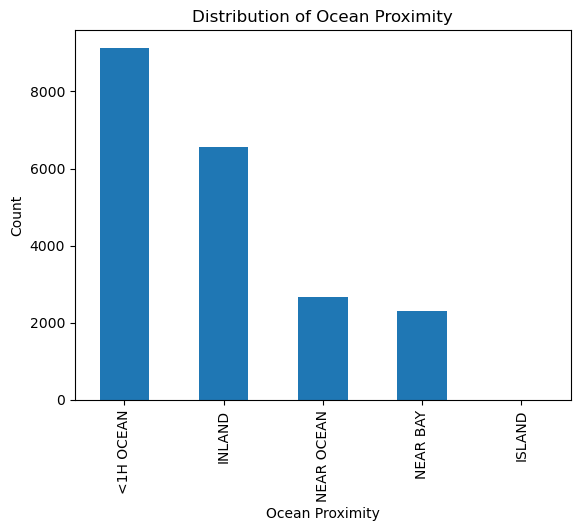

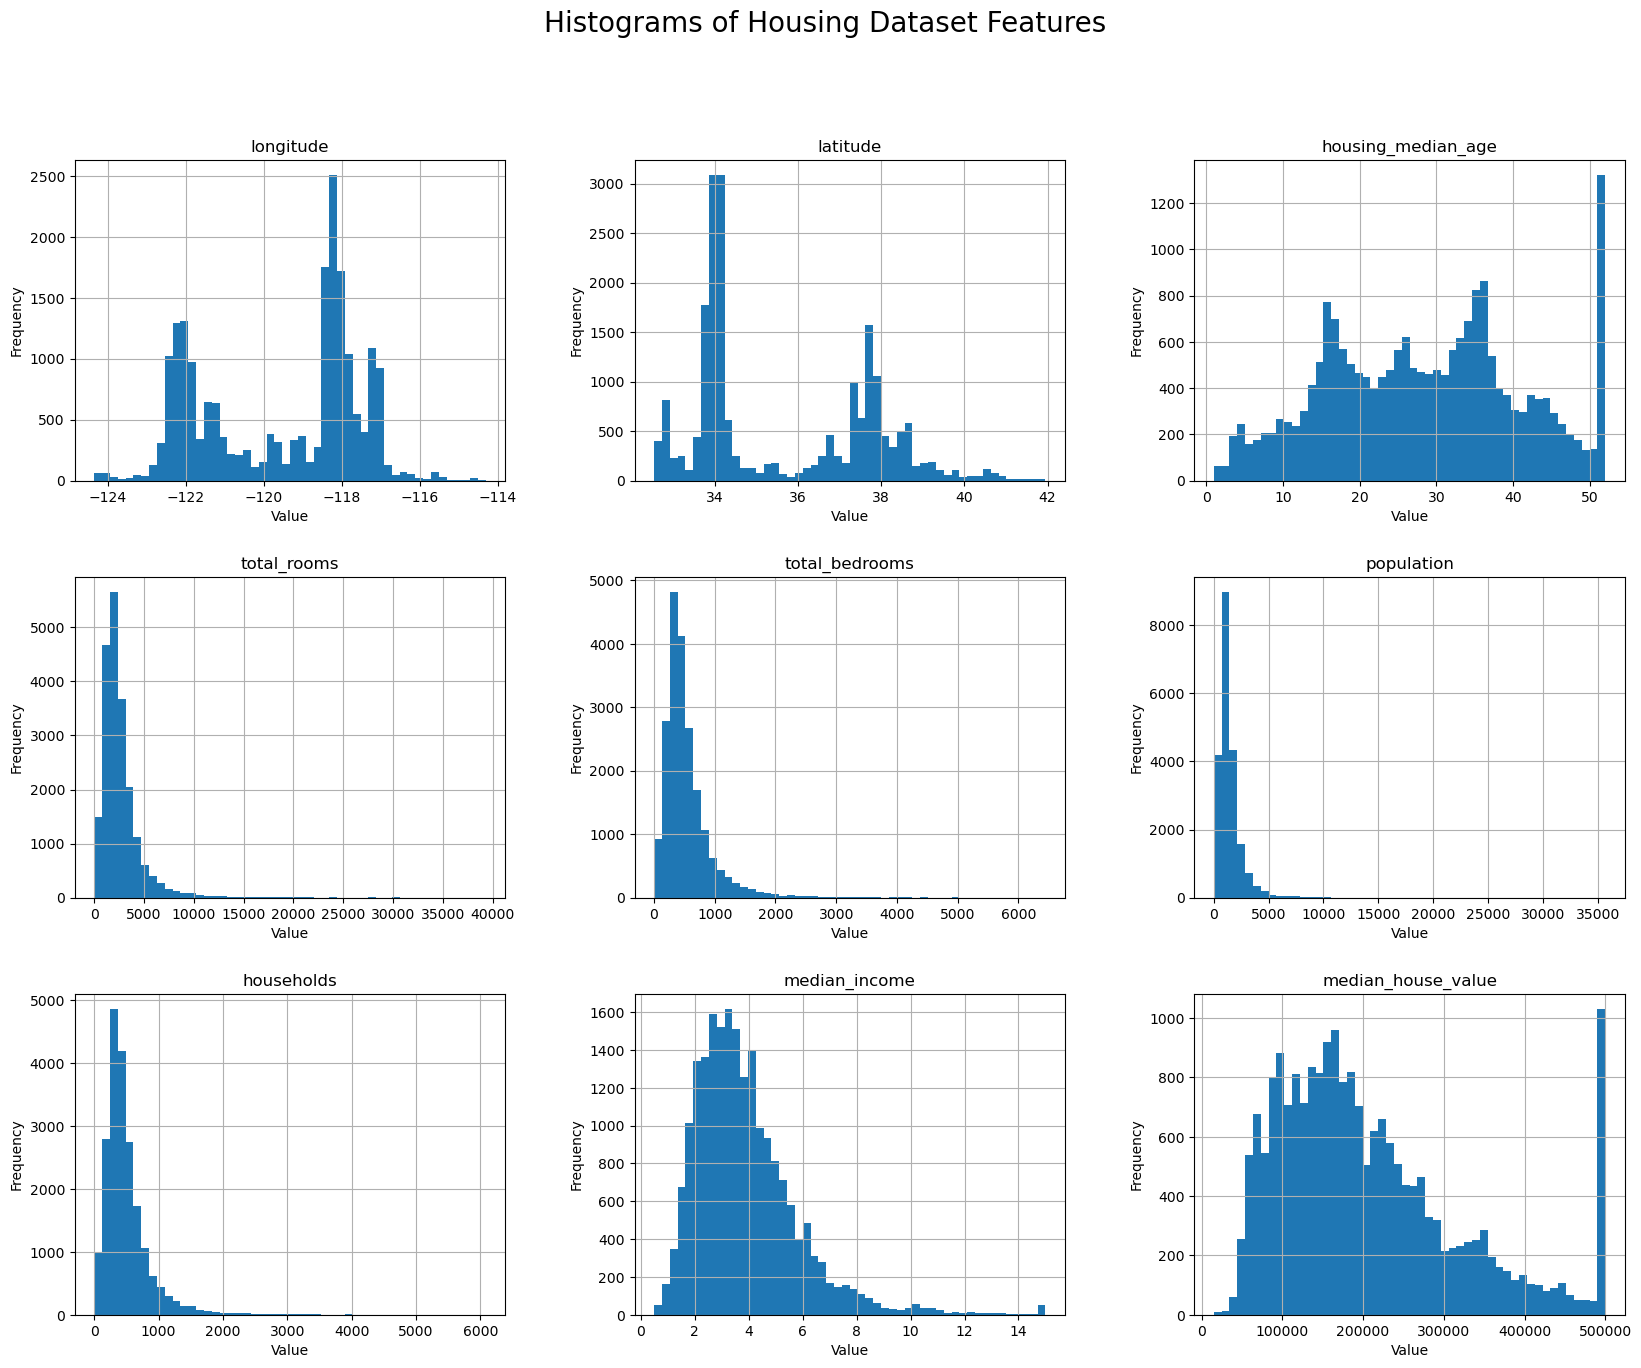

In [23]:
# EDA (Exploratory Data Analysis for understanding the data)
print(data['ocean_proximity'].value_counts())

data['ocean_proximity'].value_counts().plot(kind='bar')
plt.xlabel('Ocean Proximity')
plt.ylabel('Count')
plt.title('Distribution of Ocean Proximity')
plt.show()

axes = data.hist(bins=50, figsize=(20,15))

# Add xlabel and ylabel to each subplot
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

plt.suptitle("Histograms of Housing Dataset Features", fontsize=20)
plt.show()

In [24]:
# Separate features and target variable
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Pipeline Creation

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



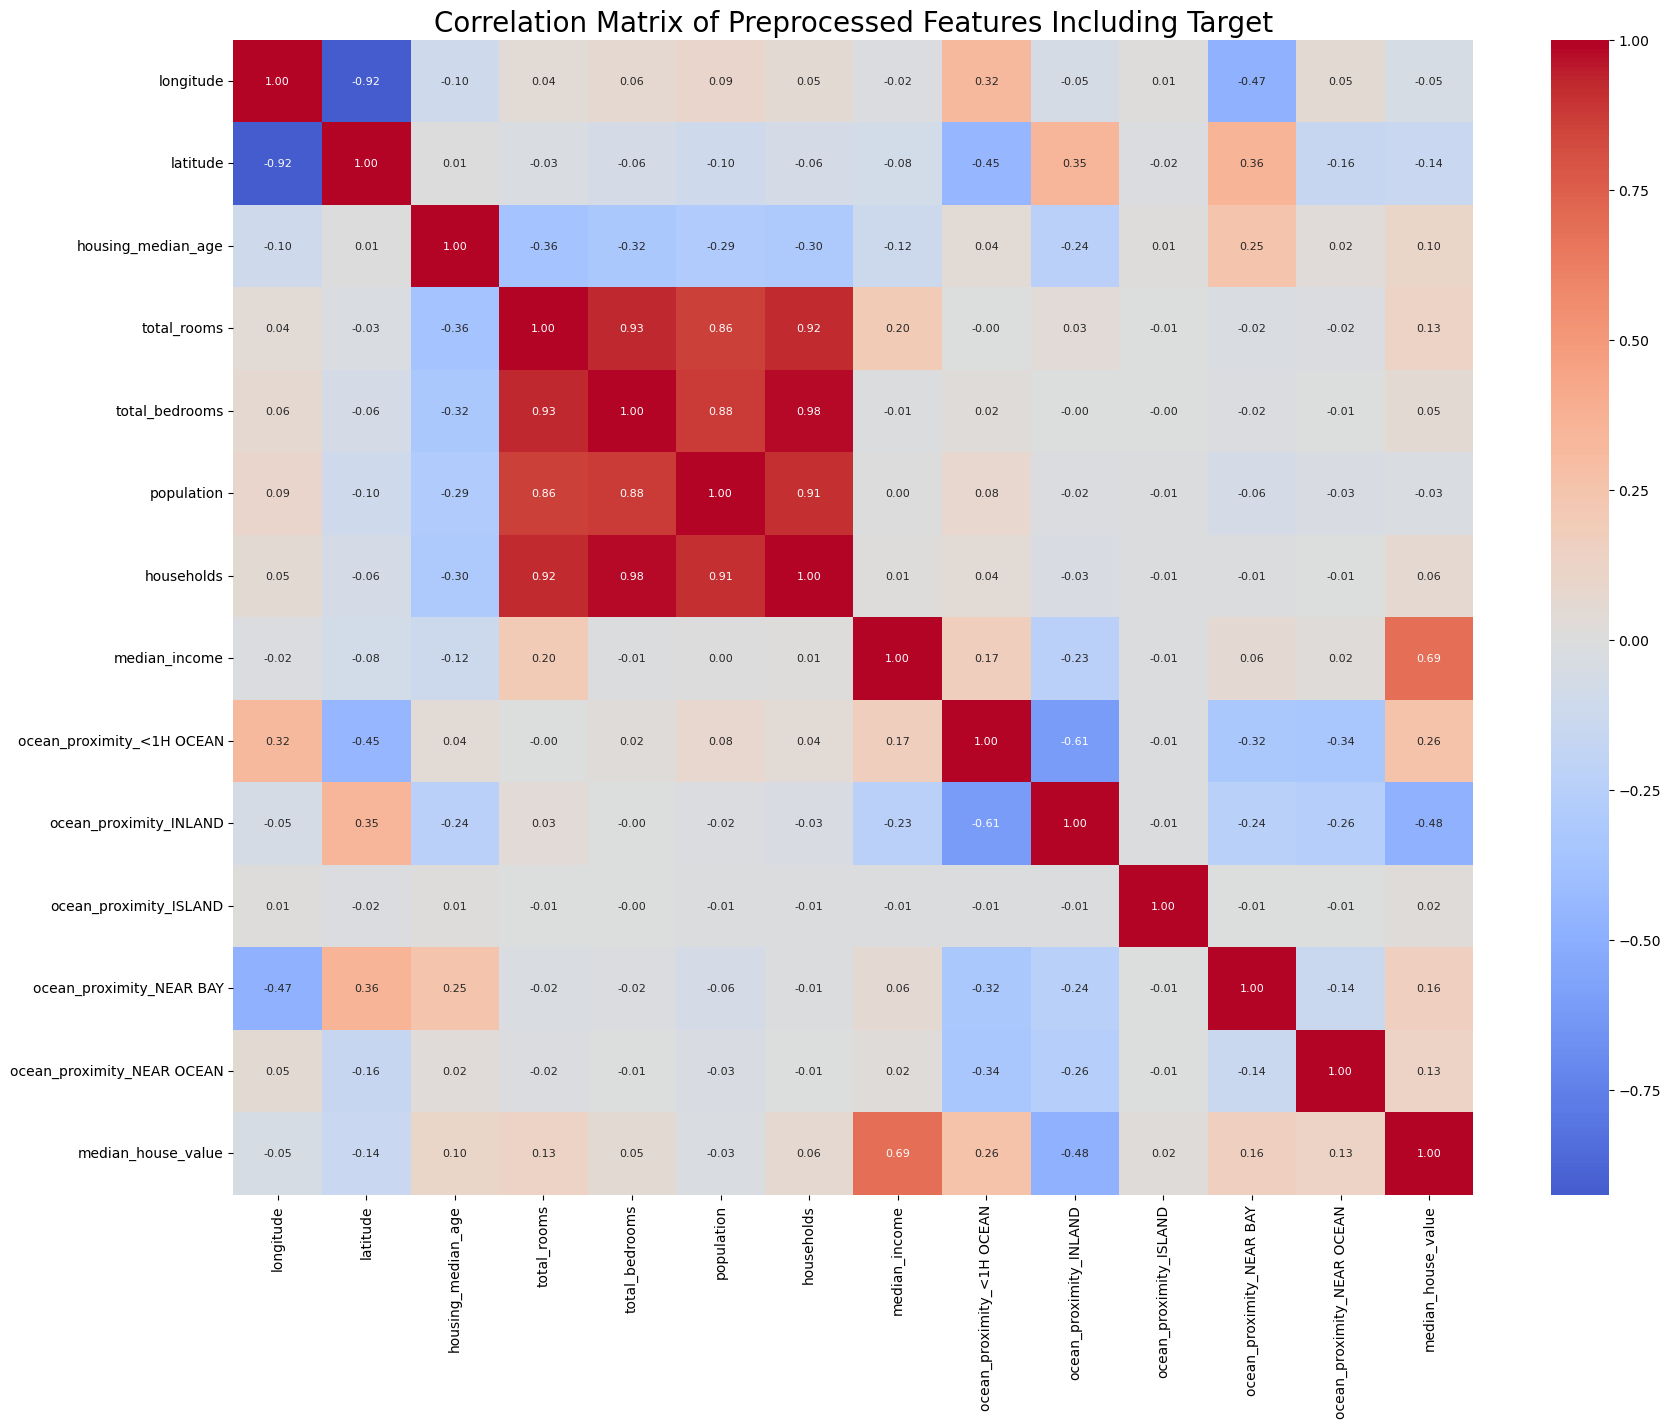

In [26]:
# Combine X_train and y_train into a single DataFrame for EDA
eda_train = X_train.copy()
eda_train['median_house_value'] = y_train
# Apply preprocessing to X_train
eda_preprocessed_X = preprocessor.fit_transform(eda_train.drop('median_house_value', axis=1))

# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

# Convert to DataFrame
eda_preprocessed_df = pd.DataFrame(eda_preprocessed_X, columns=all_feature_names, index=X_train.index)

# Add target column
eda_preprocessed_df['median_house_value'] = y_train.values

# Compute correlation
corr_matrix = eda_preprocessed_df.corr()

# Plot heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Correlation Matrix of Preprocessed Features Including Target", fontsize=20)
plt.show()


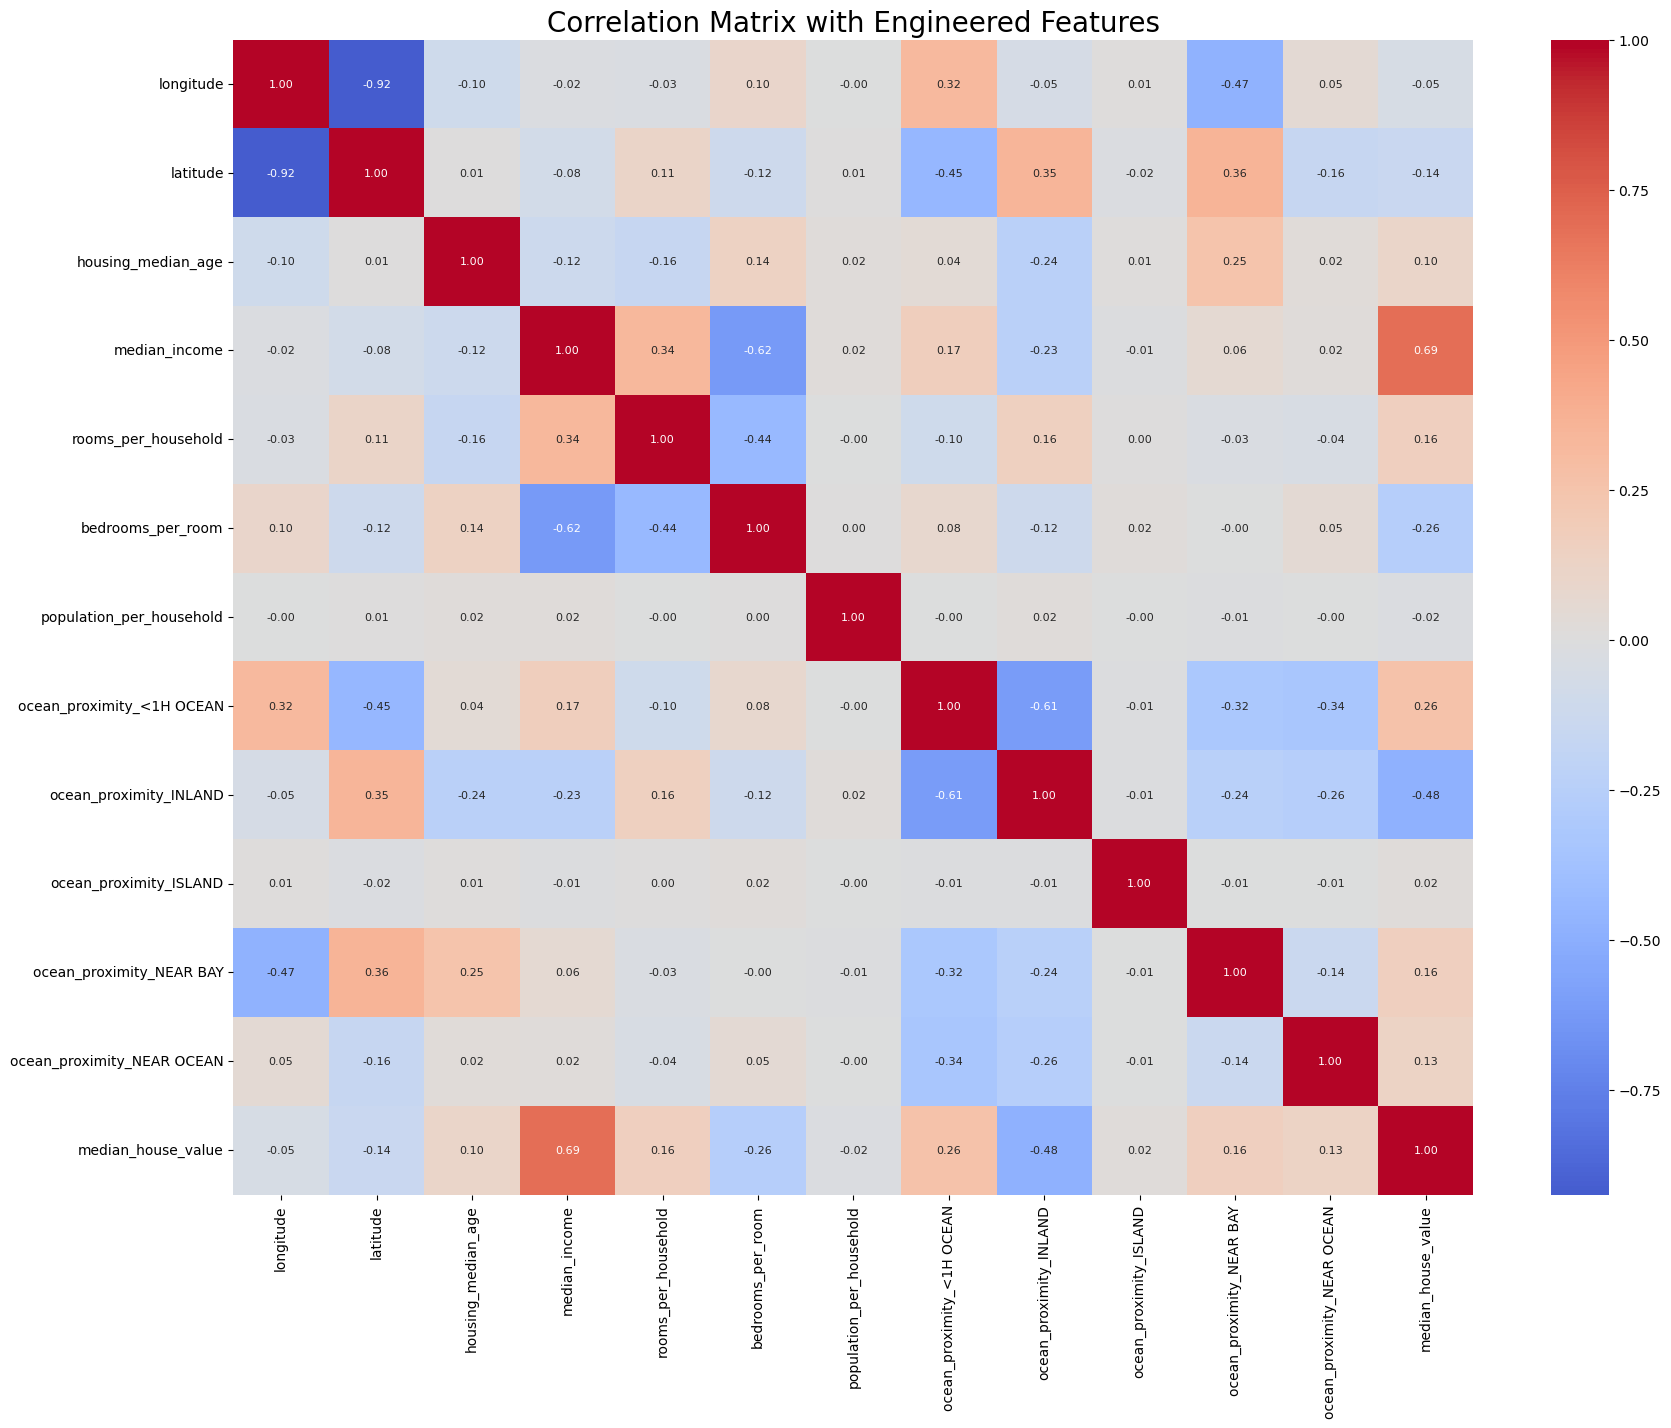

In [27]:
# Feature Engineering: Adding new features
def feature_engineering(X):
    X = X.copy()
    X['rooms_per_household'] = X['total_rooms'] / X['households']
    X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
    X['population_per_household'] = X['population'] / X['households']

    drop_cols = ['total_rooms', 'total_bedrooms', 'population', 'households']
    X = X.drop(columns=drop_cols)

    return X

# EDA with new features

# Apply feature engineering
eda_train_second = feature_engineering(X_train.copy())

# Identify numeric and categorical columns after feature engineering
numeric_cols_second = eda_train_second.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_second = eda_train_second.select_dtypes(include=['object']).columns.tolist()

# Build a new preprocessor (the same as before but for the new feature set)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_second = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols_second),
    ('cat', categorical_transformer, categorical_cols_second)
])

# Transform data
eda_preprocessed_X_second = preprocessor_second.fit_transform(eda_train_second)

# Get updated column names
ohe_feature_names = preprocessor_second.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_second)
all_feature_names_second = np.concatenate([numeric_cols_second, ohe_feature_names])

# Create DataFrame
eda_preprocessed_df_second = pd.DataFrame(
    eda_preprocessed_X_second, 
    columns=all_feature_names_second, 
    index=X_train.index
)
eda_preprocessed_df_second['median_house_value'] = y_train.values

# Correlation matrix
corr_matrix_second = eda_preprocessed_df_second.corr()

# Plot
plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix_second,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Correlation Matrix with Engineered Features", fontsize=20)
plt.show()

In [28]:
feature_adder = FunctionTransformer(feature_engineering) # Feature engineering transformer

# Full pipeline with feature engineering
full_pipeline = Pipeline(steps=[
    ('feature_adder', feature_adder),
    ('preprocessor', preprocessor_second),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Hyperparameter Tuning
param_distributions = {
    'model__max_depth': [None, 5, 10, 15, 20, 25],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4, 6]
}  

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1)


In [ ]:
# Run Randomized Search
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print("Best Hyperparameters:", random_search.best_params_)
print("Training Time (seconds):", end_time - start_time)

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R²:", r2)



Best Hyperparameters: {'model__min_samples_split': 15, 'model__min_samples_leaf': 6, 'model__max_depth': 10}
Best CV RMSE: 59283.27733652168
Training Time (seconds): 3.9481201171875
Test RMSE: 58758.64157363862
Test MAE: 39239.97202000878
Test R²: 0.7365266861789903


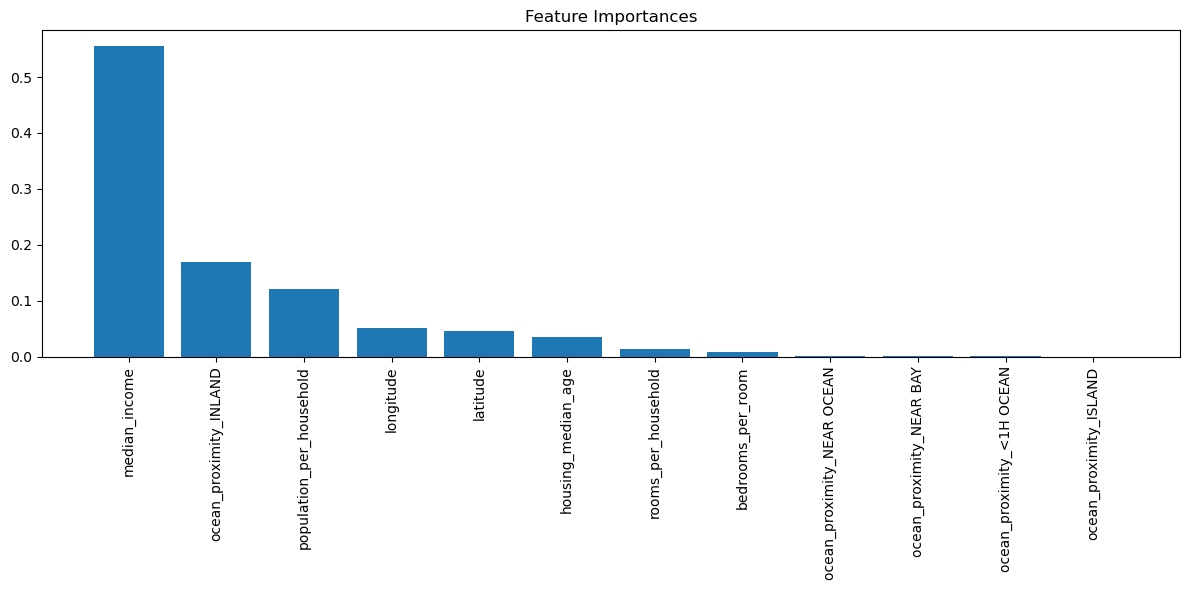

In [31]:
def plot_feature_importances(model, feature_names):
    # Check if model has feature_importances_ attribute
    if hasattr(model.named_steps['model'], 'feature_importances_'):
        importances = model.named_steps['model'].feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12,6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("The model does not have feature importances.")

# get feature importances
plot_feature_importances(best_model, all_feature_names_second)
